# 2021 Sales Analytics for The Austin Shaker

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
from datetime import date

## Now, let's go! Let's load a sales report from our inventory system, DEAR

In [2]:
#DEAR -> REPORTS -> SALES BY PRODUCT DETAILS -> [select time frame] -> EXPORT -> EXCEL WITHOUT TOTALS

df = pd.read_excel('2021details.xlsx',engine='openpyxl',header=0,skiprows=5, parse_dates=False)#parse_dates didn't work, see below
#print(df.iloc[38:45])#head is full of junk right now lol - cleaning time!

#### cleaning, we'll analyze retail only!, verify sku and product name always perfectly match before dropping sku column

In [3]:
#initial cleaning setup
list_of_retail_stores = ['Customer Square ' + str(x) for x in range(1,4)] #we have 3 stores active, we won't count the Warehouse
retail_names = ['Airport','Pleasant Valley','Oak Hill'] # make sure this matches the above list length - no known automation possible
store_map = dict(zip(list_of_retail_stores,retail_names))

ws = df[df.Customer.isin(list_of_retail_stores) == False]
df = df[df.Customer.isin(list_of_retail_stores) & df.Product.notnull()].reset_index(drop=True) #remove wholesale and weird null anomoly entries

In [4]:
#df['SKU'] = df.SKU.apply(str)
temp = df.groupby(["Product","SKU"]).count().reset_index()
temp[temp['Product'].duplicated()]

,Product,SKU,Category,Invoice Date,Customer,Quantity,Sale,COGS,Profit
2635,La Venenosa Raicilla Tutsi 750ml,799599687865,2,2,2,2,2,2,2


#### Looks like La Venenosa Tutsi (output of the above cell) is screwed up in DEAR and needs a fix. Otherwise we can assume that for each product and sku, there is only one pair. Thus, we don't need both columns (but we need to fix Tutsi and re-run the report in DEAR). While I should do the remainder by SKU, I'm lazy and want easy to read things so screw Tutsi, we're dropping SKU and going by Product Name. NOT IDEAL - now fixed in DEAR as of 11 Jan 2022 (Pete merged items)

### Final inital df cleaning - renaming, dropping unneeded columns, parsing dates, getting unit prices, etc

In [5]:
#start cleaning some of the unused or needed columns / rows, converting "Invoice Date" to datetime objects
df = df.drop(['SKU', 'COGS','Profit'], axis=1, inplace=False)#not trusted data columns or useful, we'll ignore them for now
df = df.rename(columns={'Invoice Date':'Date'})#renaming for legibility 

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%Y')#get these dates converted from string to something more powerful
df['Month'] = df.Date.apply(lambda x: x.month)#.month_name() also an option but i dont trust yet
df['Weekday'] = df.Date.apply(lambda x: x.dayofweek)#Monday is 0, Sunday is 6, day_name() also an option but i dont trust yet
df['Week'] = df.Date.apply(lambda x: x.isocalendar()[1])#x.isocalendar().week
df["Unit"] = df.Sale / df.Quantity
df.head()

,Product,Category,Date,Customer,Quantity,Sale,Month,Weekday,Week,Unit
0,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-02-06,Customer Square 2,1,67.99,2,5,5,67.99
1,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-03-10,Customer Square 2,1,67.99,3,2,10,67.99
2,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-03-17,Customer Square 2,1,67.99,3,2,11,67.99
3,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-05-08,Customer Square 1,1,67.99,5,5,18,67.99
4,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-05-08,Customer Square 2,1,67.99,5,5,18,67.99
...,...,...,...,...,...,...,...,...,...,...
151190,Gift Card,Service,2021-12-24,Customer Square 1,3,150.00,12,4,51,50.00
151191,Gift Card,Service,2021-12-24,Customer Square 2,2,80.00,12,4,51,40.00
151192,Kermit Lynch Rosato 750ml,Service,2021-05-03,Customer Square 1,1,10.99,5,0,18,10.99
151193,Margarita Salt Rimmer,Service,2021-05-05,Customer Square 1,1,7.00,5,2,18,7.00


### Let's manage some categories and make a list for just the wine. I also want to condense the minor whiskey categories into a catchall, so we'll rename those here.

In [7]:
#quick wine filter setup and check to make sure there's no items with bad categories that need fixing
#organize this better in the notebook?
active_categories = df.Category.unique().tolist()
active_categories.sort()
#print(active_categories)
wine_list = ['White','Orange Wine','Bubbles','Red New World','Red Old World','Rose']#active categories just for vino
whiskey_list = ['Whiskey American Single Malt', 'Whiskey Bourbon/American', 'Whiskey Canadian', 'Whiskey French', 'Whiskey Indian', 'Whiskey Irish', 'Whiskey Japanese', 'Whiskey Mexican', 'Whiskey Rye', 'Whiskey Scotch', 'Whiskey Taiwaneese', 'Whisky German']
itnl_whiskey = ['Whiskey French', 'Whiskey Indian', 'Whiskey Mexican', 'Whiskey Taiwaneese', 'Whisky German']

In [8]:
#fix things here
#print(df.head())
#for i, row in df.iterrows():
    #if row.Category in itnl_whiskey:
        #print(row)
        #row.Category = "Itnl Whiskey"
        #print(69,row)
    
df['Category'] = df.apply(lambda row: "Itnl Whiskey" if row.Category in itnl_whiskey else row.Category,axis=1)
#df[df.Category == 'Itnl Whiskey']

                                Product       Category       Date  \
0  Matthiasson Cabernet Sauvignon 750ml  Red New World 2021-02-06   
1  Matthiasson Cabernet Sauvignon 750ml  Red New World 2021-03-10   
2  Matthiasson Cabernet Sauvignon 750ml  Red New World 2021-03-17   
3  Matthiasson Cabernet Sauvignon 750ml  Red New World 2021-05-08   
4  Matthiasson Cabernet Sauvignon 750ml  Red New World 2021-05-08   

            Customer  Quantity   Sale  Month  Weekday  Week   Unit  
0  Customer Square 2         1  67.99      2        5     5  67.99  
1  Customer Square 2         1  67.99      3        2    10  67.99  
2  Customer Square 2         1  67.99      3        2    11  67.99  
3  Customer Square 1         1  67.99      5        5    18  67.99  
4  Customer Square 2         1  67.99      5        5    18  67.99  


,Product,Category,Date,Customer,Quantity,Sale,Month,Weekday,Week,Unit
75622,Kavalan Classic 750ml,Itnl Whiskey,2021-03-17,Customer Square 1,1,89.99,3,2,11,89.99
75623,Kavalan Classic 750ml,Itnl Whiskey,2021-08-12,Customer Square 2,1,89.99,8,3,32,89.99
75624,Kavalan Classic 750ml,Itnl Whiskey,2021-11-19,Customer Square 2,1,89.99,11,4,46,89.99
75625,Kavalan Classic 750ml,Itnl Whiskey,2021-12-23,Customer Square 3,1,89.99,12,3,51,89.99
75626,Kavalan Concertmaster 750ml,Itnl Whiskey,2021-09-20,Customer Square 3,1,89.99,9,0,38,89.99
...,...,...,...,...,...,...,...,...,...,...
145626,Paul John Nirvana 750ml,Itnl Whiskey,2021-10-30,Customer Square 2,1,32.99,10,5,43,32.99
145627,Paul John Christmas Edition 2020 750ml,Itnl Whiskey,2021-01-04,Customer Square 3,1,80.99,1,0,1,80.99
145628,Paul John Christmas Edition 2020 750ml,Itnl Whiskey,2021-01-22,Customer Square 1,1,89.99,1,4,3,89.99
145629,Paul John Christmas Edition 2020 750ml,Itnl Whiskey,2021-10-07,Customer Square 2,1,89.99,10,3,40,89.99


### if there's bad categories ^ (at item creation in DEAR) fix in DEAR and re-run report - easiest for now or manually edit here

# Start Analysis

In [9]:
#Overall best sellers:
top_sellers = df[df.Product!='Discount'].groupby(['Product']).Quantity.sum().reset_index()
top_sellers.sort_values(by='Quantity',ascending=False).reset_index(drop=True).head(15)

,Product,Quantity
0,Fireball 50ml,10756
1,New Amsterdam Pink Whitney 50ml,4803
2,E & J VS Brandy 50ml,3040
3,New Amsterdam Pineapple 50ml,2487
4,Limes (fresh),2062
5,Kentucky Deluxe 200ml,1990
6,99 Bananas 50ml,1853
7,Espolon Blanco 1L,1670
8,Tullamore Dew 50ml,1636
9,Paul Masson Brandy 50ml,1633


## Let's create a spreadsheet for analysing sales as a tool for creating pars

In [10]:
##explain
pars = df[df.Product != 'eGift Card'].groupby(['Product','Week','Customer']).Quantity.sum().reset_index()
#test = pars[(pars.Product == 'Deep Eddy Lemon 750ml') & (pars.Customer == 'Customer Square 2')].Quantity.describe()

gather = []
for product in pars.Product.unique():
    for store in list_of_retail_stores:
        qs = pars[(pars.Product == product) & (pars.Customer == store)].Quantity.to_list()
        tl = len(qs)#temporary length
        while len(qs) < 52: # eventually future proof this for any date range given
            qs.append(0)
        qs = np.array(qs)
        gather.append([product,store,tl,qs.mean(),qs.std(),qs.min(),qs.max(),np.percentile(qs,25),np.percentile(qs,50),np.percentile(qs,75)])
        
par_suggest = pd.DataFrame(gather,columns=['Product','Customer','Count','Mean','Std','Min','Max','25','50','75'])
#output.to_csv('parguide.csv',index=False)
#par_suggest.head()

In [11]:
#DEAR -> PRODUCTS -> EXPORT -> STOCK REORDER LOCATIONS

read_pars = pd.read_csv('StockReorderlocations_2022-01-21.csv',header=0,dtype=str)#parse_dates
read_pars.rename(columns={'ProductName':'Product','Location':'Customer'},inplace=True)
read_pars.drop(['StockLocator','PickZones'],inplace=True,axis=1)
read_pars.MinimumBeforeReorder = read_pars.MinimumBeforeReorder.astype(float)
read_pars.MinimumBeforeReorder = read_pars.MinimumBeforeReorder.astype(int)
read_pars.ReorderQuantity = read_pars.ReorderQuantity.astype(float)
read_pars.ReorderQuantity = read_pars.ReorderQuantity.astype(int)
#read_pars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12645 entries, 0 to 12644
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Action                12645 non-null  object
 1   ProductSKU            12645 non-null  object
 2   Product               12645 non-null  object
 3   Customer              12645 non-null  object
 4   MinimumBeforeReorder  12645 non-null  int32 
 5   ReorderQuantity       12645 non-null  int32 
dtypes: int32(2), object(4)
memory usage: 494.1+ KB


In [12]:
fixer = dict(zip(retail_names,list_of_retail_stores))
read_pars['Customer'] = read_pars.apply(lambda x: fixer[x.Customer] if x.Customer != 'Warehouse' else 'Warehouse',axis=1 )
#read_pars

In [13]:
#print(par_suggest.head())
#print(read_pars.head())
mess = par_suggest.merge(right=read_pars,on=['Product','Customer'])
mess['Unit'] = mess.apply(lambda x: df.loc[df.Product == x.Product].iloc[0].Unit,axis=1)
mess['RoundedMean'] = mess['Mean'].round()
mess['DiffMean'] = (mess['MinimumBeforeReorder'] - mess['RoundedMean']).round() 
mess['Diff75'] = (mess['MinimumBeforeReorder'] - mess['75']).round()
mess['MeanSavings'] = mess['DiffMean'] * mess['Unit']
mess['75Savings'] = mess['Diff75'] * mess['Unit']
mess.to_csv('paranalysis.csv',index=False)
#print(mess.info())
mess.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8966 entries, 0 to 8965
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product               8966 non-null   object 
 1   Customer              8966 non-null   object 
 2   Count                 8966 non-null   int64  
 3   Mean                  8966 non-null   float64
 4   Std                   8966 non-null   float64
 5   Min                   8966 non-null   int64  
 6   Max                   8966 non-null   int64  
 7   25                    8966 non-null   float64
 8   50                    8966 non-null   float64
 9   75                    8966 non-null   float64
 10  Action                8966 non-null   object 
 11  ProductSKU            8966 non-null   object 
 12  MinimumBeforeReorder  8966 non-null   int32  
 13  ReorderQuantity       8966 non-null   int32  
 14  Unit                  8930 non-null   float64
 15  RoundedMean          

,Product,Customer,Count,Mean,Std,Min,Max,25,50,75,Action,ProductSKU,MinimumBeforeReorder,ReorderQuantity,Unit,RoundedMean,DiffMean,Diff75,MeanSavings,75Savings
0,123 Organic Blanco Tequila 750ml,Customer Square 1,3,0.057692,0.233161,0,1,0.0,0.0,0.0,Create/Update,7503013136207,0,1,47.99,0.0,0.0,0.0,0.00,0.00
1,123 Organic Blanco Tequila 750ml,Customer Square 2,7,0.153846,0.410657,0,2,0.0,0.0,0.0,Create/Update,7503013136207,1,3,47.99,0.0,1.0,1.0,47.99,47.99
2,123 Organic Blanco Tequila 750ml,Customer Square 3,0,0.000000,0.000000,0,0,0.0,0.0,0.0,Create/Update,7503013136207,0,1,47.99,0.0,0.0,0.0,0.00,0.00
3,123 Organic Reposado Tequila 750ml,Customer Square 1,3,0.057692,0.233161,0,1,0.0,0.0,0.0,Create/Update,7503013136214,0,1,56.99,0.0,0.0,0.0,0.00,0.00
4,123 Organic Reposado Tequila 750ml,Customer Square 2,4,0.076923,0.266469,0,1,0.0,0.0,0.0,Create/Update,7503013136214,1,3,56.99,0.0,1.0,1.0,56.99,56.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8961,Zucca Rabarbaro 750ml,Customer Square 2,10,0.211538,0.453047,0,2,0.0,0.0,0.0,Create/Update,050037033755,12,6,32.99,0.0,12.0,12.0,395.88,395.88
8962,Zucca Rabarbaro 750ml,Customer Square 3,4,0.076923,0.266469,0,1,0.0,0.0,0.0,Create/Update,050037033755,1,6,32.99,0.0,1.0,1.0,32.99,32.99
8963,Zwack Liqueur 750ml,Customer Square 1,7,0.153846,0.410657,0,2,0.0,0.0,0.0,Create/Update,088076168909,1,6,15.98,0.0,1.0,1.0,15.98,15.98
8964,Zwack Liqueur 750ml,Customer Square 2,7,0.134615,0.341312,0,1,0.0,0.0,0.0,Create/Update,088076168909,1,6,15.98,0.0,1.0,1.0,15.98,15.98


In [14]:
#let's generate something we can upload to DEAR
par_gen = mess[['Action','ProductSKU','Product','Customer','75','ReorderQuantity']].copy()
par_gen = par_gen.rename(columns={'Product':'ProductName','Customer':'Location','75':'MinimumBeforeReorder'})
par_gen = par_gen[par_gen.Location == 'Customer Square 3']
par_gen.MinimumBeforeReorder = par_gen.MinimumBeforeReorder.round().astype(int)
par_gen['Stock Locator'] = par_gen['PickZones'] = ''
par_gen.to_csv('OakHillParGenerator.csv',index=False)
#par_gen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2807 entries, 2 to 8965
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Action                2807 non-null   object
 1   ProductSKU            2807 non-null   object
 2   ProductName           2807 non-null   object
 3   Location              2807 non-null   object
 4   MinimumBeforeReorder  2807 non-null   int32 
 5   ReorderQuantity       2807 non-null   int32 
 6   Stock Locator         2807 non-null   object
 7   PickZones             2807 non-null   object
dtypes: int32(2), object(6)
memory usage: 175.4+ KB


In [15]:
print(mess[mess.Customer == 'Customer Square 2'].MeanSavings.sum(),mess[mess.Customer == 'Customer Square 2']['75Savings'].sum())
print(mess.MeanSavings.sum(),mess['75Savings'].sum())

409586.97308333335 398428.401125
756295.1105972222 729651.7854166668


## Wine Analysis

In [16]:
#top sellers
wine_pivot = df[df['Category'].isin(wine_list)].pivot_table(columns=['Customer'],index='Product',values='Quantity',aggfunc='sum')
#wine_pivot.rename(columns={'Customer Square 1':'Airport','Customer Square 2':'PleasantValley','Customer Square 3':'OakChill'},inplace=True)
wine_pivot.rename(columns=store_map,inplace=True)
wine_pivot.fillna(0,inplace=True)
wine_pivot['Total'] = wine_pivot.iloc[1:].sum(axis=1)
wine_pivot.sort_values('Total',ascending=False).head(15)

Customer,Airport,Pleasant Valley,Oak Hill,Total
Product,,,,
Better Half Sauvignon Blanc 750ml,383.0,469.0,75.0,927.0
El Jefe Tempranillo 1L,316.0,216.0,37.0,569.0
Wycliff Brut 750ml,132.0,308.0,0.0,440.0
Alias Cabernet Sauvignon 750ml,61.0,269.0,9.0,339.0
Chasing Lions Cabernet Sauvignon 750ml,130.0,177.0,18.0,325.0
Tintero Rosato 750ml,72.0,105.0,102.0,279.0
Foxglove Cabernet Sauvignon 750ml,103.0,118.0,47.0,268.0
Glinavos Paleokerisio Orange Wine 500ml,136.0,116.0,9.0,261.0
Lunaria Pinot Grigio Pet Nat 750ml,169.0,79.0,11.0,259.0


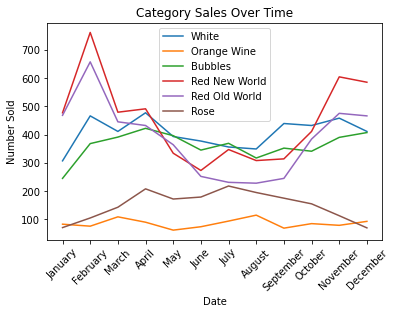

In [17]:
#lets make a plot showing the change in category sales over the year
linegraph = df[df["Product"].str.contains(" 50m")==False] #remove minis
linegraph = linegraph.groupby(['Category','Month']).Quantity.sum().reset_index()#example, (pd.Grouper(key='Date', freq='1M')) gave some weird results for January and doing by raw month should allow for multiple years later
#print(linegraph.iloc[9:15])

months=["January","February","March","April","May","June","July","August","September","October","November","December"]
test_list = ["Rum","Mezcal","Whiskey Scotch","Gin","Sake","Itnl Whiskey"]

fig, ax = plt.subplots()
for cat in wine_list:
    ax.plot(linegraph[linegraph.Category == cat].Month,linegraph[linegraph.Category == cat].Quantity,label = cat)

ax.set_xticks(range(1,13))
ax.set_xticklabels(months,rotation=45)
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Category Sales Over Time')
plt.legend()#show it!
plt.show()

### Pie chart showing wine category sales by unit volume

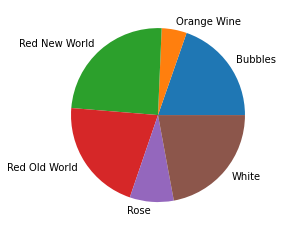

In [18]:
piechart = linegraph[linegraph.Category.isin(wine_list)].groupby('Category').Quantity.sum().reset_index()
#print(piechart)
plt.pie(piechart.Quantity,labels=piechart.Category)
plt.show()

### Sales per Store per Period compared

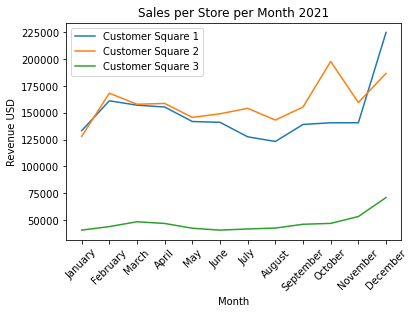

In [19]:
#lets show each store by month
#print(df[df["Weekday"]==6].head())# should we drop gift cards entirely? do they get double counted for revenue on these reports?
square = df[df['Weekday']!=6].groupby(['Customer','Month']).Sale.sum().reset_index()

fig, ax = plt.subplots()
for store in list_of_retail_stores:
    ax.plot(square[square['Customer']==store].Month,(square[square['Customer']==store].Sale),label=store)

ax.set_xticks(range(1,13))
ax.set_xticklabels(months,rotation=45)
plt.xlabel('Month')
plt.ylabel('Revenue USD')
plt.title('Sales per Store per Month 2021')
plt.legend()#show it!
plt.show()

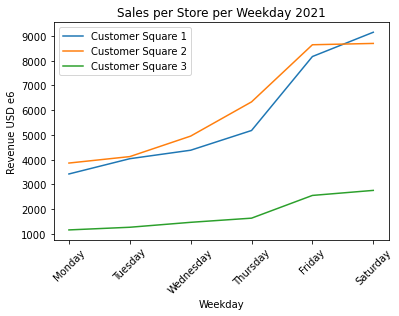

In [20]:
#lets show each store by day
#print(df[df["Weekday"]==6].head())# should we drop gift cards entirely? do they get double counted for revenue on these reports?
square = df[df['Weekday']!=6].groupby(['Customer','Weekday']).Sale.sum().reset_index()

fig, ax = plt.subplots()
for store in list_of_retail_stores:
    ax.plot(square[square['Customer']==store].Weekday,(square[square['Customer']==store].Sale / 52),label=store)

ax.set_xticks(range(0,6))
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],rotation=45)
plt.xlabel('Weekday')
plt.ylabel('Revenue USD e6')
plt.title('Sales per Store per Weekday 2021')
plt.legend()#show it!
plt.show()

In [21]:
#lets do a histogram for item sales by price bracket, tequila let's go?

#hist = df.groupby('Product').agg({'Unit':'max','Quantity':'sum','Category':'first'}).reset_index()
hist = df[df["Product"].str.contains(" 50m")==False].groupby('Product').agg({'Unit':'max','Quantity':'sum'}).reset_index()
#hist["Price"] = hist.apply(find_price,axis=1)
#print(hist.head())
hist_dump = []
for index, row in hist.iterrows():
    if row.Unit>=0.99: #could put a filter here like category
        for i in range(0,row.Quantity):
            hist_dump.append(row.Unit)
hist_dump[0:(hist.Quantity.iloc[0]+1)]#show that its working


[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 59.99]

#### we have the histogram info setup, now lets get it into a nice looking bar graph. there's a non-ideal implementation of the x tick labels that i need to address eventually but it's working fine enough for now

<ipython-input-23-f6b06a800c30>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels,rotation=90)


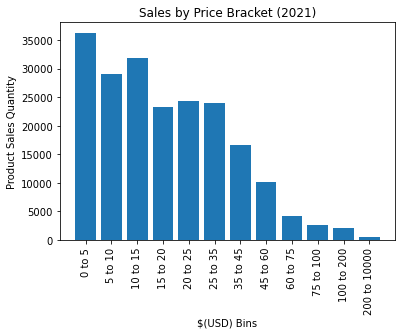

In [23]:
bins = [0,5,10,15,20,25,35,45,60,75,100,200,10000] #edit however, just make sure last bin is set high enough to capture all
mydata = pd.DataFrame(hist_dump)

n, _ = np.histogram(mydata, bins=bins)
labels = [f'{a} to {b}' for a, b in zip(bins, bins[1:])]

fig, ax = plt.subplots()
bar = ax.bar(labels, n)
ax.set_xticklabels(labels,rotation=90)
#_ = ax.bar_label(bar)
plt.xlabel('$(USD) Bins')
plt.ylabel('Product Sales Quantity')
plt.title('Sales by Price Bracket (2021)')
plt.show()

## Shelf Space Allocation Efficiency

### essentially, looking at how well certain categories sell compared to the amount of space they occupy. example: if you have 5 bottles of red wine and 5 white, but sell 2x the amount of white, then you could consider downsizing reds or bringing in more whites. These are ranked with a ratio

In [24]:
#comparing how many we have of each category vs how well that sells (shelf space allocation)
sku_start = df[df["Product"].str.contains(" 50m")==False] #remove minis
sku_start = sku_start[sku_start['Category'].str.contains("Fruit|Service|Ice") == False]#these categories dont take space, add more
#sku_start["Revenue"] = sku_start.Quantity * sku_start.Price
#print(sku_start.head())

sku_space = sku_start.groupby('Category').Product.unique().reset_index()
sku_space['Count'] = sku_space.apply(lambda x: np.size(x.Product) ,axis=1)
sku_space['Percent'] = sku_space.apply(lambda x: x.Count / sku_space.Count.sum(), axis=1)
#print(sku_space.head())

sku_volume = sku_start.groupby('Category').Quantity.sum().reset_index()
sku_volume['Percent'] = sku_volume.apply(lambda x: x.Quantity / sku_volume.Quantity.sum(),axis=1)
#print(sku_volume.head())

sku_revenue = sku_start.groupby('Category').Sale.sum().reset_index()
sku_revenue['ofIncome'] = sku_revenue.Sale / sku_revenue.Sale.sum()
#print(sku_revenue.head())

sku_look = sku_space.drop(['Product','Count'],axis=1)#cleaning unused row
sku_look['ofSales'] = sku_volume.Percent #combining things
sku_look.rename(columns={'Percent':'ofSpace'},inplace=True) 
sku_look['RatioSpace'] = sku_look.ofSales / sku_look.ofSpace #high number is a GOOD performer
sku_look.sort_values(by=['Category'],inplace=True,ascending=True)
sku_look['ofIncome'] = sku_revenue['ofIncome']
sku_look['RatioSales'] = sku_look.ofIncome / sku_look.ofSpace
sku_look.to_csv('shelfspaceallocation.csv',index=False)
sku_look.head(10)

,Category,ofSpace,ofSales,RatioSpace,ofIncome,RatioSales
0,Absinthe,0.004257,0.000957,0.224714,0.001773,0.416521
1,Amaro,0.022631,0.025578,1.130245,0.025758,1.138212
2,Aquavit,0.001344,0.000191,0.142319,0.000306,0.227935
3,Bacanora,0.000448,0.000111,0.247185,0.000299,0.666478
4,Bag,0.002241,0.001918,0.856160,0.000246,0.109999
5,Baijiu,0.000672,0.000151,0.224714,0.000185,0.275895
6,Bar Tools,0.032265,0.021520,0.666964,0.013261,0.411007
7,Bitters,0.037195,0.013141,0.353315,0.009345,0.251247
8,Books,0.009635,0.001254,0.130125,0.001646,0.170879
9,Brandy,0.012324,0.026142,2.121300,0.011954,0.970004


In [25]:
#cognac has some weird numbers, looks like its just all the high dollar Henny sales
#yak_investigation = df[df.Category == 'Cognac'].groupby(['Product']).Quantity.sum().reset_index()
#yak_investigation.sort_values('Quantity',ascending=False)

In [26]:
df

,Product,Category,Date,Customer,Quantity,Sale,Month,Weekday,Week,Unit
0,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-02-06,Customer Square 2,1,67.99,2,5,5,67.99
1,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-03-10,Customer Square 2,1,67.99,3,2,10,67.99
2,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-03-17,Customer Square 2,1,67.99,3,2,11,67.99
3,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-05-08,Customer Square 1,1,67.99,5,5,18,67.99
4,Matthiasson Cabernet Sauvignon 750ml,Red New World,2021-05-08,Customer Square 2,1,67.99,5,5,18,67.99
...,...,...,...,...,...,...,...,...,...,...
151190,Gift Card,Service,2021-12-24,Customer Square 1,3,150.00,12,4,51,50.00
151191,Gift Card,Service,2021-12-24,Customer Square 2,2,80.00,12,4,51,40.00
151192,Kermit Lynch Rosato 750ml,Service,2021-05-03,Customer Square 1,1,10.99,5,0,18,10.99
151193,Margarita Salt Rimmer,Service,2021-05-05,Customer Square 1,1,7.00,5,2,18,7.00


## Let's do a quick wholesale Par creation speedrun

In [ ]:
ws.Customer = 'Warehouse'
ws = ws.drop(['SKU', 'COGS','Profit'], axis=1, inplace=False)#not trusted data columns or useful, we'll ignore them for now
ws = ws.rename(columns={'Invoice Date':'Date'})#renaming for legibility 

In [29]:
ws['Date'] = pd.to_datetime(ws['Date'], format='%d-%b-%Y')#get these dates converted from string to something more powerful
ws['Month'] = ws.Date.apply(lambda x: x.month)#.month_name() also an option but i dont trust yet
ws['Weekday'] = ws.Date.apply(lambda x: x.dayofweek)#Monday is 0, Sunday is 6, day_name() also an option but i dont trust yet
ws['Week'] = ws.Date.apply(lambda x: x.isocalendar()[1])#x.isocalendar().week
ws["Unit"] = ws.Sale / df.Quantity

ws['Category'] = ws.apply(lambda row: "Itnl Whiskey" if row.Category in itnl_whiskey else row.Category,axis=1)
ws[ws.Category == 'Itnl Whiskey']

ws

,Product,Category,Date,Customer,Quantity,Sale,Month,Weekday,Week,Unit
39,Fidencio Mezcal 750ml,Mezcal,2021-03-08,Warehouse,1,29.50,3,0,10,29.5
40,Fidencio Mezcal 750ml,Mezcal,2021-03-10,Warehouse,1,29.50,3,2,10,29.5
45,Fidencio Mezcal 750ml,Mezcal,2021-03-23,Warehouse,1,29.50,3,1,12,29.5
50,Fidencio Mezcal 750ml,Mezcal,2021-04-07,Warehouse,1,29.50,4,2,14,29.5
52,Fidencio Mezcal 750ml,Mezcal,2021-04-14,Warehouse,1,29.50,4,2,15,29.5
...,...,...,...,...,...,...,...,...,...,...
257398,Discount,Service,2021-12-20,Warehouse,1,-8.49,12,0,51,NaN
257405,Discount,Service,2021-12-22,Warehouse,1,-5.07,12,2,51,NaN
257409,Discount,Service,2021-12-23,Warehouse,3,-64.14,12,3,51,NaN
257422,Discount,Service,2021-12-29,Warehouse,2,-32.79,12,2,52,NaN


In [30]:
top_ws = ws[ws.Product!='Discount'].groupby(['Product']).Quantity.sum().reset_index()
top_ws.sort_values(by='Quantity',ascending=False).reset_index(drop=True).head(15)

,Product,Quantity
0,Richards Rainwater Sparkling 12oz Bottles,38576
1,Topo Chico 12oz Bottles,24186
2,Titos 1L,20680
3,Espolon Blanco 1L,13333
4,Tullamore Dew 50ml,10080
5,Lunazul Blanco 1L,8635
6,Cimarron Blanco 1L,8522
7,Coke Can 12oz,7875
8,Del Maguey Vida 750ml,6328
9,Underberg,6190


In [31]:
pars_ws = ws[ws.Product != 'eGift Card'].groupby(['Product','Week','Customer']).Quantity.sum().reset_index()

gather = []
for product in pars_ws.Product.unique():
    qs = pars_ws[(pars_ws.Product == product)].Quantity.to_list()
    tl = len(qs)#temporary length
    while len(qs) < 52: # eventually future proof this for any date range given
        qs.append(0)
    qs = np.array(qs)
    gather.append([product,store,tl,qs.mean(),qs.std(),qs.min(),qs.max(),np.percentile(qs,25),np.percentile(qs,50),np.percentile(qs,75)])
        
par_ws_suggest = pd.DataFrame(gather,columns=['Product','Customer','Count','Mean','Std','Min','Max','25','50','75'])
par_ws_suggest.head()

,Product,Customer,Count,Mean,Std,Min,Max,25,50,75
0,123 Organic Anejo Tequila 750ml,Customer Square 3,1,0.019231,0.137335,0,1,0.00,0.0,0.0
1,123 Organic Blanco Tequila 750ml,Customer Square 3,2,0.038462,0.192308,0,1,0.00,0.0,0.0
2,123 Organic Reposado Tequila 750ml,Customer Square 3,3,0.057692,0.233161,0,1,0.00,0.0,0.0
3,1792 Bottled In Bond 750ml,Customer Square 3,5,0.134615,0.439792,0,2,0.00,0.0,0.0
4,1792 Bottled In Bond Nickel City Barrel 750ml,Customer Square 3,3,0.115385,0.505883,0,3,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2859,Zing Zang Bloody Mary Mix 1.75L,Customer Square 3,2,0.153846,0.863459,0,6,0.00,0.0,0.0
2860,Zing Zang Bloody Mary Mix PET 32oz,Customer Square 3,46,20.346154,14.978041,0,56,10.75,19.0,28.5
2861,Zirbenz Stone Pine Liqueur 750ml,Customer Square 3,12,0.384615,0.812258,0,4,0.00,0.0,0.0
2862,Zubrowka Bison Grass Vodka 750ml,Customer Square 3,6,0.500000,1.956252,0,11,0.00,0.0,0.0


In [32]:
prep_ws = par_ws_suggest.merge(right=read_pars,on=['Product','Customer'])
prep_ws['Unit'] = prep_ws.apply(lambda x: ws.loc[ws.Product == x.Product].iloc[0].Unit,axis=1)
prep_ws['RoundedMean'] = prep_ws['Mean'].round()
prep_ws['DiffMean'] = (prep_ws['MinimumBeforeReorder'] - prep_ws['RoundedMean']).round() 
prep_ws['Diff75'] = (prep_ws['MinimumBeforeReorder'] - prep_ws['75']).round()
prep_ws['MeanSavings'] = prep_ws['DiffMean'] * prep_ws['Unit']
prep_ws['75Savings'] = prep_ws['Diff75'] * prep_ws['Unit']
prep_ws.to_csv('paranalysisWAREHOUSE.csv',index=False)
#print(prep_ws.info())
prep_ws.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 1727
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product               1728 non-null   object 
 1   Customer              1728 non-null   object 
 2   Count                 1728 non-null   int64  
 3   Mean                  1728 non-null   float64
 4   Std                   1728 non-null   float64
 5   Min                   1728 non-null   int64  
 6   Max                   1728 non-null   int64  
 7   25                    1728 non-null   float64
 8   50                    1728 non-null   float64
 9   75                    1728 non-null   float64
 10  Action                1728 non-null   object 
 11  ProductSKU            1728 non-null   object 
 12  MinimumBeforeReorder  1728 non-null   int32  
 13  ReorderQuantity       1728 non-null   int32  
 14  Unit                  871 non-null    float64
 15  RoundedMean          

,Product,Customer,Count,Mean,Std,Min,Max,25,50,75,Action,ProductSKU,MinimumBeforeReorder,ReorderQuantity,Unit,RoundedMean,DiffMean,Diff75,MeanSavings,75Savings
0,123 Organic Blanco Tequila 750ml,Customer Square 3,2,0.038462,0.192308,0,1,0.0,0.0,0.0,Create/Update,7503013136207,0,1,NaN,0.0,0.0,0.0,NaN,NaN
1,123 Organic Reposado Tequila 750ml,Customer Square 3,3,0.057692,0.233161,0,1,0.0,0.0,0.0,Create/Update,7503013136214,0,1,NaN,0.0,0.0,0.0,NaN,NaN
2,1792 Bottled In Bond 750ml,Customer Square 3,5,0.134615,0.439792,0,2,0.0,0.0,0.0,Create/Update,088004027971,2,6,30.94,0.0,2.0,2.0,61.88,61.88
3,1792 Full Proof 750ml,Customer Square 3,7,0.153846,0.410657,0,2,0.0,0.0,0.0,Create/Update,080660001159,1,6,34.95,0.0,1.0,1.0,34.95,34.95
4,1792 Small Batch Bourbon 750ml,Customer Square 3,4,0.076923,0.266469,0,1,0.0,0.0,0.0,Create/Update,080660001203,2,6,14.00,0.0,2.0,2.0,28.00,28.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,Yzaguirre Rojo 1L,Customer Square 3,1,0.019231,0.137335,0,1,0.0,0.0,0.0,Create/Update,890004001017,2,6,NaN,0.0,2.0,2.0,NaN,NaN
1724,Zephyr Gin 750ml,Customer Square 3,33,3.596154,4.438726,0,25,0.0,2.0,6.0,Create/Update,869641000004,1,6,NaN,4.0,-3.0,-5.0,NaN,NaN
1725,Zirbenz Stone Pine Liqueur 750ml,Customer Square 3,12,0.384615,0.812258,0,4,0.0,0.0,0.0,Create/Update,9006794140008,1,3,NaN,0.0,1.0,1.0,NaN,NaN
1726,Zubrowka Bison Grass Vodka 750ml,Customer Square 3,6,0.500000,1.956252,0,11,0.0,0.0,0.0,Create/Update,5900343008129,1,12,177.66,0.0,1.0,1.0,177.66,177.66


In [33]:
#let's generate something we can upload to DEAR
par_gen = prep_ws[['Action','ProductSKU','Product','Customer','75','ReorderQuantity']].copy()
par_gen = par_gen.rename(columns={'Product':'ProductName','Customer':'Location','75':'MinimumBeforeReorder'})
#par_gen = par_gen[par_gen.Location == 'Customer Square 3']
par_gen.MinimumBeforeReorder = par_gen.MinimumBeforeReorder.round().astype(int)
par_gen['Stock Locator'] = par_gen['PickZones'] = ''
par_gen.to_csv('WAREHOUSEParGenerator.csv',index=False)
#par_gen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 1727
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Action                1728 non-null   object
 1   ProductSKU            1728 non-null   object
 2   ProductName           1728 non-null   object
 3   Location              1728 non-null   object
 4   MinimumBeforeReorder  1728 non-null   int32 
 5   ReorderQuantity       1728 non-null   int32 
 6   Stock Locator         1728 non-null   object
 7   PickZones             1728 non-null   object
dtypes: int32(2), object(6)
memory usage: 108.0+ KB


In [36]:
print(prep_ws.MeanSavings.sum(),prep_ws['75Savings'].sum())

-401615.8947838273 -643988.1882354867


### ah fuck so whole is super weird because its not just 1 order placed per week, fuck